<a href="https://colab.research.google.com/github/zzyunzhi/scene-language/blob/main/colab/text_to_scene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text-to-3D generation using the Scene Language.
[[Paper](https://arxiv.org/abs/2410.16770)]
[[Page](https://ai.stanford.edu/~yzzhang/projects/scene-language/)]
[[Code](https://github.com/zzyunzhi/scene-language)]

# Installation

In [1]:
# This is required by transforms3d for python 3.11.
# You will need to restart the session once afterwards.
!pip install "numpy<2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
!cd /content/ && git clone https://github.com/zzyunzhi/scene-language.git
!cd /content/scene-language && pip install -e .

Cloning into 'scene-language'...
remote: Enumerating objects: 2232, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 2232 (delta 132), reused 193 (delta 94), pack-reused 1962 (from 1)
Receiving objects: 100% (2232/2232), 147.61 MiB | 27.40 MiB/s, done.
Resolving deltas: 100% (784/784), done.
Obtaining file:///content/scene-language
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.4 MB/s eta 0:00

In [2]:
%cd /content/scene-language

/content/scene-language


In [3]:
from pathlib import Path
import anthropic
import json
import sys

from engine.utils.argparse_utils import setup_save_dir, modify_string_for_file
from engine.constants import ENGINE_MODE, PROJ_DIR
import engine.utils.claude_client

from scripts.run_utils import SYSTEM_HEADER, run, SYSTEM_RULES, read_example, save_prompts

sys.path.append((Path(PROJ_DIR) / "scripts/prompts").as_posix())

from scripts.prompts.impl_preset import core
from helper import *

[INFO] Reading header from /content/scene-language/scripts/outputs/stubgen/20241020-145124-exposed-calc/header.pyi.
[INFO] Implementing placeholder...
[INFO] Implementing primitive_call...


# Set LLM prompts

In [4]:
### Set your scene description here. ###
task = "A city."

In [5]:
system_prompt = """\
You are a code completion model and can only write python functions wrapped within ```python```.

You are provided with the following `helper.py` which defines the given functions and definitions:
```python
{header}
```

{rules}

You should be precise and creative.
""".format(
    header=SYSTEM_HEADER, rules=SYSTEM_RULES
)


user_prompt = '''Here are some examples of how to use `helper.py`:
```python
{example}
```
IMPORTANT: THE FUNCTIONS ABOVE ARE JUST EXAMPLES, YOU CANNOT USE THEM IN YOUR PROGRAM!

Now, write a similar program for the given task:
```python
from helper import *

"""
{task}
"""
```
'''.format(
    task=task,
    example=read_example(animate=False),
)

In [6]:
save_dir = Path("/content/outputs")
save_dir.mkdir(exist_ok=True)

name = modify_string_for_file(task)
save_subdir = save_dir / name
save_subdir.mkdir(exist_ok=True)
print(f"Outputs will be saved under {save_subdir}.")

# save system prompt and user prompt as .txt files
save_prompts(save_subdir.as_posix(), system_prompt, user_prompt)

Outputs will be saved under /content/outputs/A_city_fe0415be-2b08-5074-8e3e-bca203bd21be.


# Query LLM and render

### Option 1: Run with web chat interface

**Step 1**: Copy and paste the texts below to an LLM web interface, e.g., https://claude.ai/new. We recommend using Claude Sonnet 3.7.


In [7]:
print(system_prompt + "\n" + user_prompt)

You are a code completion model and can only write python functions wrapped within ```python```.

You are provided with the following `helper.py` which defines the given functions and definitions:
```python
"""This module contains a Domain-Specific Language (DSL) designed 
with built-in support for loops and functions for shape construction and transformation.
"""

from typing import NamedTuple, Any, Callable, Literal
import math
import numpy as np

# type aliases and DSL syntax sugar
P = Any  # 3D vector, e.g., a point or direction
T = Any  # 4x4 transformation matrix
Shape = list[dict[str, Any]]  # a shape is a list of primitive shapes

# shape function library utils

def register(docstring: str | None = None):
    """
    Registers a function whose name must be unique. You can pass in a docstring (optional).

    Every function you register MUST be invoked via `library_call`, and cannot be invoked directly via the function name.
    """
def library_call(func_name: str, **kwargs) -> 

**Step 2**: Copy and paste LLM's reponse from the web interface to the cell below.

In [8]:
# @title
###### Replace this cell with LLM's output program. ######

from helper import *

"""
A city.
"""

@register()
def building(width: float, height: float, depth: float, color: tuple[float, float, float]) -> Shape:
    """Create a simple building with given dimensions and color."""
    return primitive_call('cube', shape_kwargs={'scale': (width, height, depth)}, color=color)

@register()
def skyscraper(width: float, height: float, depth: float) -> Shape:
    """Create a tall skyscraper building."""
    # Main building
    main = library_call('building', width=width, height=height, depth=depth,
                       color=(0.7, 0.7, 0.8))  # Light gray/blue

    # Add a "roof" feature - like a small cube on top
    roof_height = height * 0.1
    roof = library_call('building', width=width*0.5, height=roof_height, depth=depth*0.5,
                      color=(0.6, 0.6, 0.7))  # Slightly darker than main building

    # Position the roof on top of the main building
    roof = transform_shape(roof, translation_matrix((0, height/2 + roof_height/2, 0)))

    return concat_shapes(main, roof)

@register()
def residential_building(width: float, height: float, depth: float) -> Shape:
    """Create a residential building."""
    # Main structure
    main = library_call('building', width=width, height=height, depth=depth,
                      color=(0.9, 0.7, 0.6))  # Light brownish

    # Add a roof
    roof_height = height * 0.2
    roof = library_call('building', width=width, height=roof_height, depth=depth,
                      color=(0.8, 0.4, 0.3))  # Reddish roof

    # Position the roof on top of the main building
    roof = transform_shape(roof, translation_matrix((0, height/2 + roof_height/2, 0)))

    return concat_shapes(main, roof)

@register()
def road(length: float, width: float = 0.3) -> Shape:
    """Create a road segment."""
    return primitive_call('cube', shape_kwargs={'scale': (length, 0.01, width)},
                        color=(0.2, 0.2, 0.2))  # Dark gray

@register()
def tree(height: float = 0.5) -> Shape:
    """Create a simple tree with trunk and foliage."""
    # Trunk
    trunk = primitive_call('cylinder',
                         shape_kwargs={'radius': 0.05, 'p0': (0, 0, 0), 'p1': (0, height * 0.4, 0)},
                         color=(0.6, 0.3, 0.1))  # Brown

    # Foliage (simple sphere)
    foliage = primitive_call('sphere', shape_kwargs={'radius': height * 0.3},
                           color=(0.1, 0.7, 0.1))  # Green

    # Position foliage on top of trunk
    foliage = transform_shape(foliage, translation_matrix((0, height * 0.4, 0)))

    return concat_shapes(trunk, foliage)

@register()
def park(width: float, depth: float, num_trees: int = 6) -> Shape:
    """Create a park with grass and trees."""
    # Base (grass)
    base = primitive_call('cube', shape_kwargs={'scale': (width, 0.01, depth)},
                        color=(0.3, 0.8, 0.3))  # Green

    # Add trees
    def place_tree(i: int) -> Shape:
        # Place trees in a somewhat random pattern
        # Use modulo and division to create a grid-like layout with randomness
        grid_size = int(math.ceil(math.sqrt(num_trees)))
        row = i % grid_size
        col = i // grid_size

        # Calculate position with some randomness
        x = (row / (grid_size - 1 or 1) - 0.5) * width * 0.8 + np.random.uniform(-0.1, 0.1)
        z = (col / (grid_size - 1 or 1) - 0.5) * depth * 0.8 + np.random.uniform(-0.1, 0.1)

        tree_shape = library_call('tree')
        return transform_shape(tree_shape, translation_matrix((x, 0.01, z)))

    trees = loop(num_trees, place_tree)

    return concat_shapes(base, trees)

@register()
def city_block(width: float, depth: float, is_downtown: bool = False) -> Shape:
    """Create a city block with multiple buildings."""

    def create_building(i: int) -> Shape:
        # Randomize building properties
        b_width = width * 0.3 * np.random.uniform(0.7, 1.0)
        b_depth = depth * 0.3 * np.random.uniform(0.7, 1.0)

        # Determine building type and height based on location and randomness
        if is_downtown or np.random.random() > 0.7:  # More skyscrapers downtown
            b_height = np.random.uniform(1.0, 2.5 if is_downtown else 1.5)
            building = library_call('skyscraper', width=b_width, height=b_height, depth=b_depth)
        else:
            b_height = np.random.uniform(0.3, 0.7)
            building = library_call('residential_building', width=b_width, height=b_height, depth=b_depth)

        # Position within the block - create a 2x2 grid
        row = i % 2
        col = i // 2

        # Calculate coordinates with some randomness
        x_offset = (row - 0.5) * width * 0.7 + np.random.uniform(-0.1, 0.1)
        z_offset = (col - 0.5) * depth * 0.7 + np.random.uniform(-0.1, 0.1)

        return transform_shape(building, translation_matrix((x_offset, b_height/2, z_offset)))

    # Create 4 buildings per block (2x2 grid)
    return loop(4, create_building)

@register()
def city_landmark() -> Shape:
    """Create a landmark building for the city center."""
    # Create a tall, distinctive central building
    main_tower = library_call('building', width=0.8, height=3.0, depth=0.8,
                            color=(0.7, 0.7, 0.9))  # Light blue-gray

    # Add a distinctive top (e.g., a sphere)
    top = primitive_call('sphere', shape_kwargs={'radius': 0.4},
                       color=(0.8, 0.8, 1.0))  # Lighter blue

    # Position the top on the tower
    top = transform_shape(top, translation_matrix((0, 1.5 + 0.4, 0)))

    return concat_shapes(main_tower, top)

@register()
def block_with_surroundings(block_idx: int, num_blocks: int, block_size: float) -> Shape:
    """Create a city block with surrounding roads."""
    # Calculate block position (in a grid)
    row = block_idx % num_blocks
    col = block_idx // num_blocks

    # Calculate center position for this block
    block_x = (row - num_blocks/2 + 0.5) * block_size
    block_z = (col - num_blocks/2 + 0.5) * block_size

    # Determine if this block is downtown (near center)
    is_downtown = (abs(row - num_blocks//2) <= 1) and (abs(col - num_blocks//2) <= 1)

    # Determine block type
    if row == num_blocks//2 and col == num_blocks//2:
        # City center - landmark
        block = library_call('city_landmark')
        # Add a small park next to the landmark
        park = library_call('park', width=block_size*0.5, depth=block_size*0.5, num_trees=4)
        park = transform_shape(park, translation_matrix((block_size*0.25, 0, block_size*0.25)))
        block = concat_shapes(block, park)
    elif np.random.random() < 0.15:
        # Park
        block = library_call('park', width=block_size*0.9, depth=block_size*0.9, num_trees=6)
    else:
        # Regular building block
        block = library_call('city_block', width=block_size*0.9, depth=block_size*0.9, is_downtown=is_downtown)

    # Position the block
    block = transform_shape(block, translation_matrix((block_x, 0, block_z)))

    return block

@register()
def city_roads(num_blocks: int, block_size: float) -> Shape:
    """Create the road grid for the city."""
    road_width = 0.3
    city_size = num_blocks * block_size

    # Create horizontal roads (along x-axis)
    def horizontal_road(i: int) -> Shape:
        z_pos = (i / num_blocks - 0.5) * city_size
        road = library_call('road', length=city_size, width=road_width)
        return transform_shape(road, translation_matrix((0, 0.011, z_pos)))  # Slightly above ground

    # Create vertical roads (along z-axis)
    def vertical_road(i: int) -> Shape:
        x_pos = (i / num_blocks - 0.5) * city_size
        road = library_call('road', length=city_size, width=road_width)
        # Rotate the road 90 degrees around Y axis
        road = transform_shape(road, rotation_matrix(math.pi/2, (0, 1, 0), (0, 0, 0)))
        return transform_shape(road, translation_matrix((x_pos, 0.011, 0)))  # Slightly above ground

    h_roads = loop(num_blocks + 1, horizontal_road)
    v_roads = loop(num_blocks + 1, vertical_road)

    return concat_shapes(h_roads, v_roads)

@register()
def city(size: float = 10.0, num_blocks: int = 5) -> Shape:
    """Create a complete city with buildings, roads, and parks."""
    block_size = size / num_blocks

    # Create all city blocks
    def create_block(i: int) -> Shape:
        return library_call('block_with_surroundings', block_idx=i, num_blocks=num_blocks, block_size=block_size)

    blocks = loop(num_blocks * num_blocks, create_block)

    # Create the road grid
    roads = library_call('city_roads', num_blocks=num_blocks, block_size=block_size)

    # Ground plane (optional)
    ground = primitive_call('cube', shape_kwargs={'scale': (size, 0.01, size)}, color=(0.6, 0.6, 0.6))
    ground = transform_shape(ground, translation_matrix((0, -0.005, 0)))  # Slightly below everything else

    return concat_shapes(ground, blocks, roads)

Now we'll make a function call to the last function from the above program, which will recursively call other functions and compute a data object corresponding to the full scene. Then, we render the data object into pixels.

This process will take a few minutes if the scene is complex. Alternatively, you can render it locally following instructions [here](https://github.com/zzyunzhi/scene-language/blob/main/scripts/tests/test_basic.py).

In [9]:
render_save_subdir = save_subdir / "0/renderings"
render_save_subdir.mkdir(exist_ok=True, parents=True)
core(engine_modes=[], overwrite=True, save_dir=render_save_subdir.as_posix())

[WARNING] Failed to import neural pipelines.
[INFO] ('/content/outputs/A_city_fe0415be-2b08-5074-8e3e-bca203bd21be/0/renderings',){}
[INFO] (None,){'verbose': False}
[INFO] ('/content/outputs/A_city_fe0415be-2b08-5074-8e3e-bca203bd21be/0/renderings',){'verbose': False}
[INFO] (None, [[None], [None]]){'col_type': 'text'}
[WARNING] no roots specified, using the last function in the library
[INFO] calling node (supposed to be root): city
[INFO] registering children for building with 161 hist calls
[INFO] registering children for skyscraper with 40 hist calls
[INFO] registering children for residential_building with 40 hist calls
[INFO] registering children for road with 12 hist calls
[INFO] registering children for tree with 28 hist calls
[INFO] registering children for park with 5 hist calls
[INFO] registering children for city_block with 20 hist calls
[INFO] registering children for city_landmark with 1 hist calls
[INFO] registering children for block_with_surroundings with 25 hist call

**Step 3**: Please skip option 2 below and directly jump to the last cell in this notebook.

### Option 2: Run with LLM API keys

Running this script for one task prompt will consume ~`2.1k * NUM_COMPLETIONS` input tokens (as long as your task description is not crazily long) and <= `MAX_OUTPUT_TOKENS * NUM_COMPLETIONS` output tokens.
The exact input token counts will be displayed below before the actual LLM query.

In [ ]:
# Please check https://docs.anthropic.com/en/api/overview#accessing-the-api
# if you are not sure what it is.
ANTHROPIC_API_KEY = ""
MAX_OUTPUT_TOKENS = 8192  # Decrease for lower cost budget
NUM_COMPLETIONS = 2

engine.utils.claude_client.ANTHROPIC_API_KEY = ANTHROPIC_API_KEY
engine.utils.claude_client.MAX_TOKENS = MAX_OUTPUT_TOKENS

In [ ]:
client = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

response = client.messages.count_tokens(
    model=engine.utils.claude_client.CLAUDE_MODEL_NAME,
    system=system_prompt,
    messages=[{
        "role": "user",
        "content": user_prompt,
    }],
)
print(f'The following cell will query {engine.utils.claude_client.CLAUDE_MODEL_NAME} {NUM_COMPLETIONS} times.')
print(f'In total, it will cost {json.loads(response.model_dump_json())["input_tokens"] * NUM_COMPLETIONS} input tokens \
and <= {MAX_OUTPUT_TOKENS * NUM_COMPLETIONS} output tokens.')


Running the following sesison multiple times the same system, user prompt, and temperature will retrieve cached results, even if you changed `MAX_OUTPUT_TOKENS`.
This means that you need to increase `num_completions` or manually remove `/content/scene-language/cache.json` for new queries.

In [ ]:
_ = run(
    save_dir=save_subdir.as_posix(),
    user_prompt=user_prompt,
    system_prompt=system_prompt,
    extra_info={"task": task},
    lm_config={
        "num_completions": NUM_COMPLETIONS,
        "temperature": 0.2,
    },
)

# View renderings

Displaying /content/outputs/A_city_fe0415be-2b08-5074-8e3e-bca203bd21be/0/renderings/exposed_city_rover_background_rendering_traj.gif


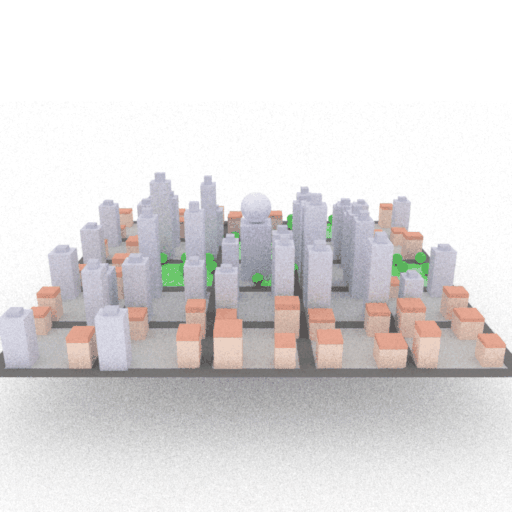

In [10]:
from IPython.display import Image

for p in save_dir.glob("*/*/renderings/*.gif"):
    print(f"Displaying {p}")
    display(Image(filename=p))